# Insurance Modeling Problem

Problem: Develop and compare six different machine learning regression models to predict clients’ insurance charges ->
1. Perform an EDA
2. Preprocess the data
3. Build the models
4. Explain the outputs

## Import necessary libraries

In [1]:
# Import basic libraries
import pandas as pd
import numpy as np
import pickle

# Import plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import scatter_matrix

# Import data preprocessing and metric evaluation libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Import ML Regression libraries
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

# For hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\PratyushShukla\miniconda3\envs\ml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Set global variables
URL = "https://open-data.s3.filebase.com/insurance.csv"
FILE_NAME = "insurance_model.pkl"

## Reading data and providing its details

In [3]:
data = pd.read_csv(URL)
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


We find that there are 3 object types columns: 'sex', 'smoker', 'region', which are asctually categorical variables. We will convert them to categorical columns and then apply Label Encoding for proper fitting of the model. We can also see that there are no Null values in the dataset. We double check that with isnull() function.

In [5]:
data.isnull().any()

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

There are no Null values! Next we providethe statistics summary of the dataset.

In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


A quick analysis shows that the insurance charge is higher for older people and is significantly affected by BMI. This holds true according to the real-life facts.

## Exploratory Data Analsysis and Data Preprocessing 

We separate the numerical and categorical columns for easier analysis.

In [7]:
numerical = ['age', 'bmi', 'children', 'charges']
categorical = ['smoker', 'region', 'sex']

data = data[categorical+numerical]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   smoker    1338 non-null   object 
 1   region    1338 non-null   object 
 2   sex       1338 non-null   object 
 3   age       1338 non-null   int64  
 4   bmi       1338 non-null   float64
 5   children  1338 non-null   int64  
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Plotting the numerical features first, we can observe the distribution over the dataset.

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'children'}>,
        <AxesSubplot:title={'center':'charges'}>]], dtype=object)

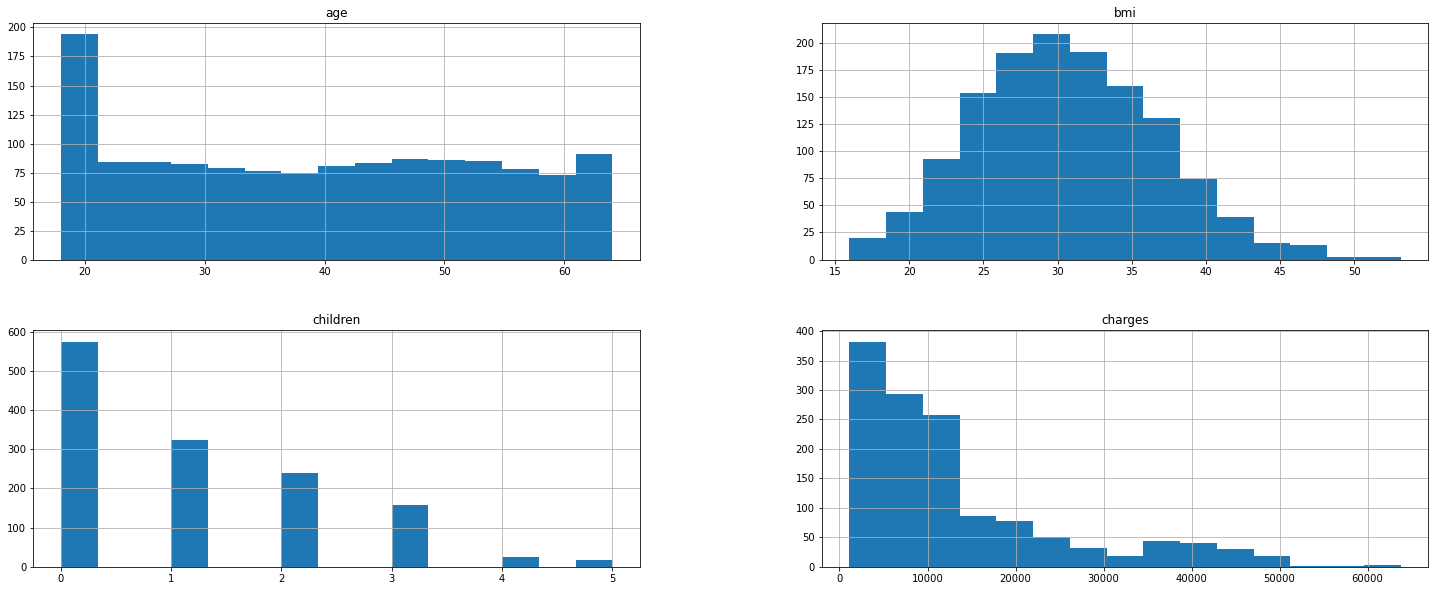

In [8]:
data[numerical].hist(bins=15, figsize=(25, 10), layout=(2, 2))

From the above histograms, we can observe the following:
1. There are significantly more younger people in the dataset.
2. The BMI spread is following a normal distribution.
3. There are more people with no children.
4. The spread of charges is left skewed.

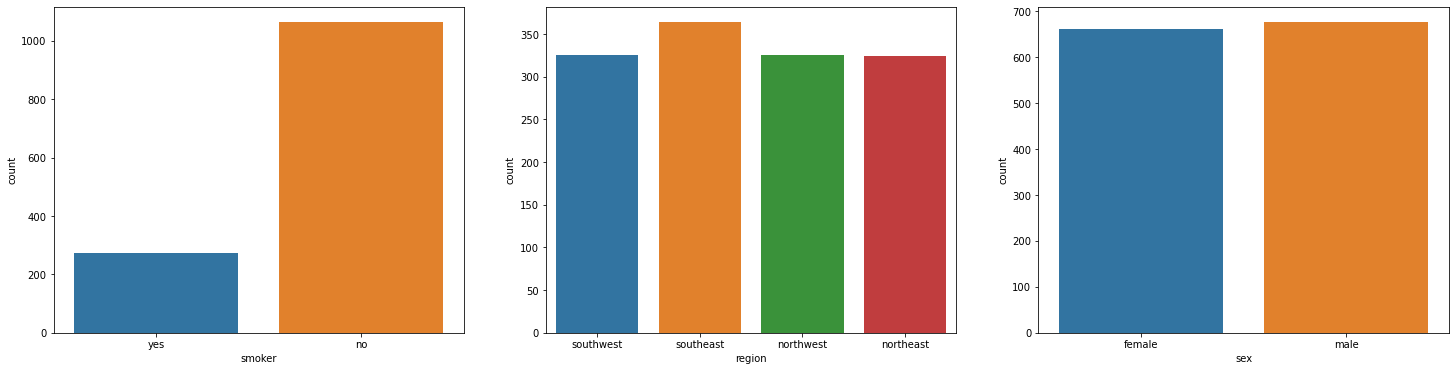

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))

for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(x=data[variable], ax=subplot)

There are equal number of males and females. People tend to be more from southeast region and all other regions are comparably equal. Also, there are more smokers in the dataset.

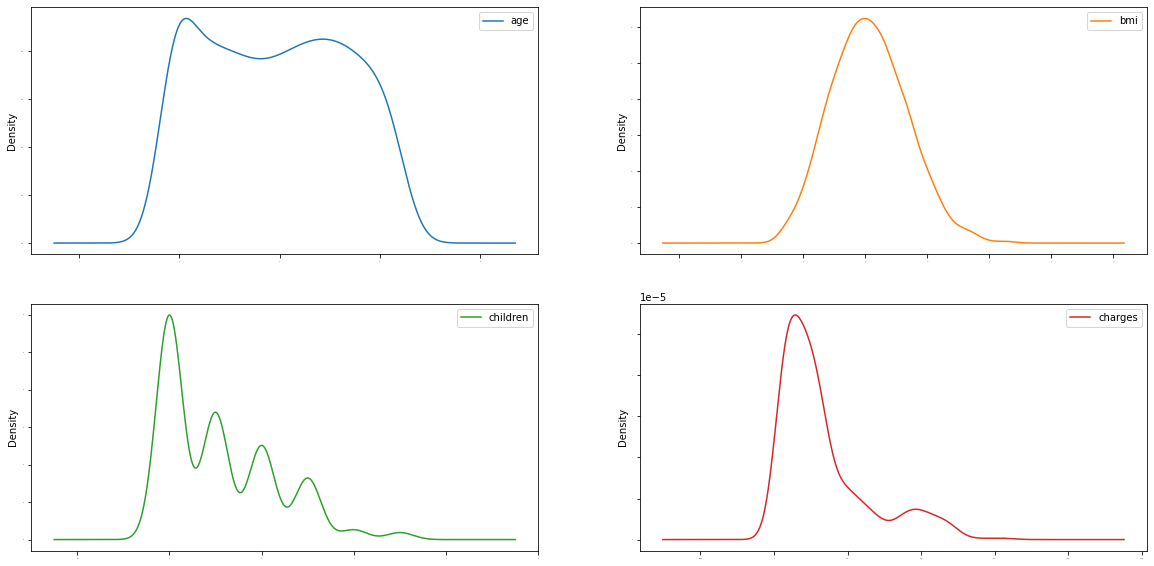

In [10]:
data.plot(kind='density', subplots=True, layout=(2,2), sharex=False, legend=True, fontsize=1, figsize=(20,10))
plt.show()

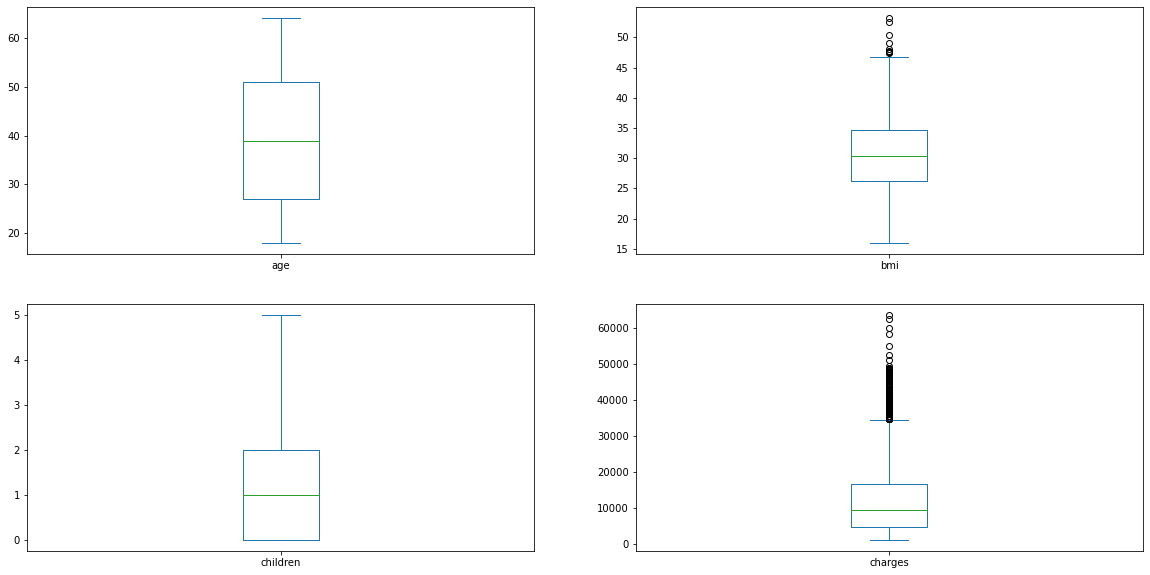

In [11]:
data.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False, figsize=(20,10))
plt.show()

From observations from the above plots, it can be confirmed that on an average there are middle aged people with normal BMI, less than 1 children and they have lesser charges.<br/>
This means that the insurance charge will be more for larger families where there are more aged people in the household.

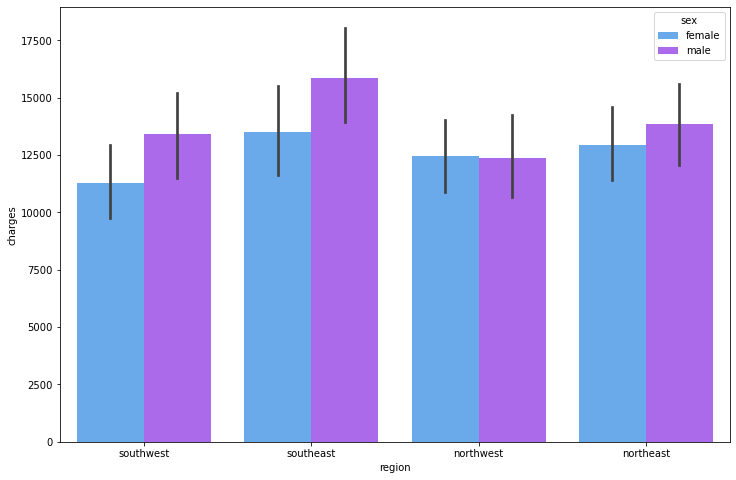

In [12]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='sex', data=data, palette='cool')

In northwest there are comparably more females than males and vice versa in the other regions. Overall the highest charges are in the southeast and the lowest are in the southwest.<br/>
In the northeast there are higher charges by gender than in the southwest and northwest regions.

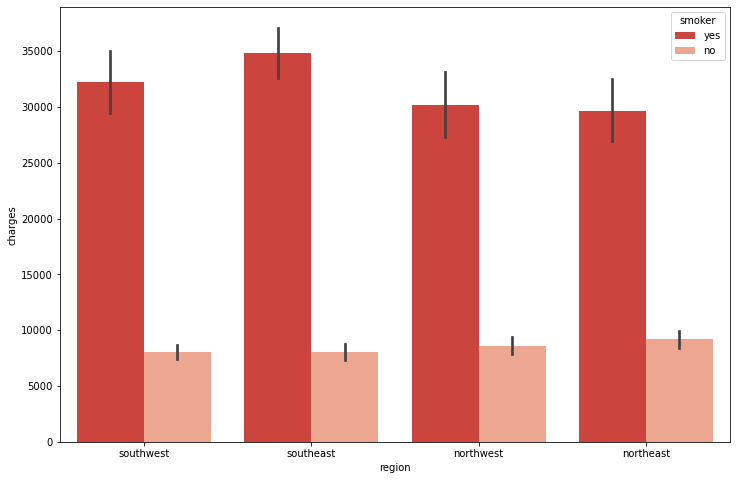

In [13]:
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.barplot(x = 'region', y = 'charges', hue='smoker', data=data, palette='Reds_r')

From the barplots, the highest charges due to smoking are still in the southeast but the lowest ones in the northeast.

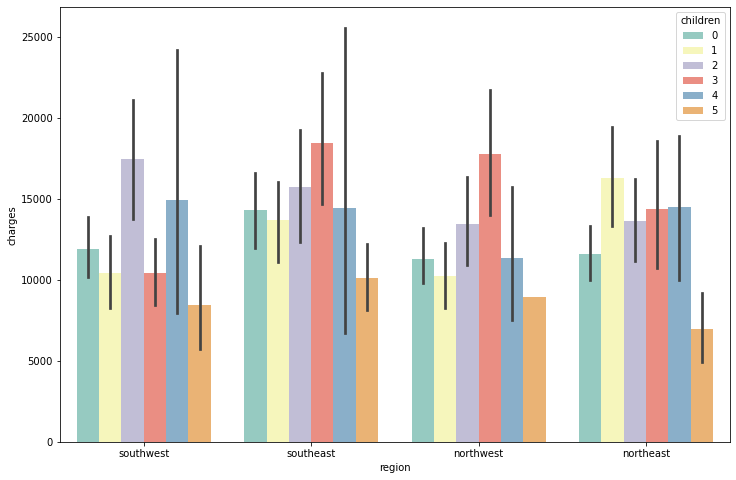

In [14]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='children', data=data, palette='Set3')

 People with more than 1 children tend to have higher medical costs.

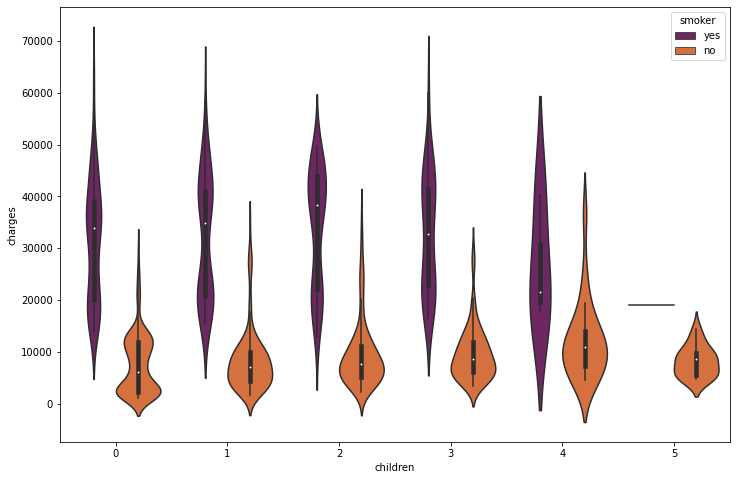

In [15]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.violinplot(x = 'children', y = 'charges', data=data, orient='v', hue='smoker', palette='inferno')

Smoking has the highest impact on medical costs, than all other features. Also people who have children generally smoke less, as shown by the following violinplots.

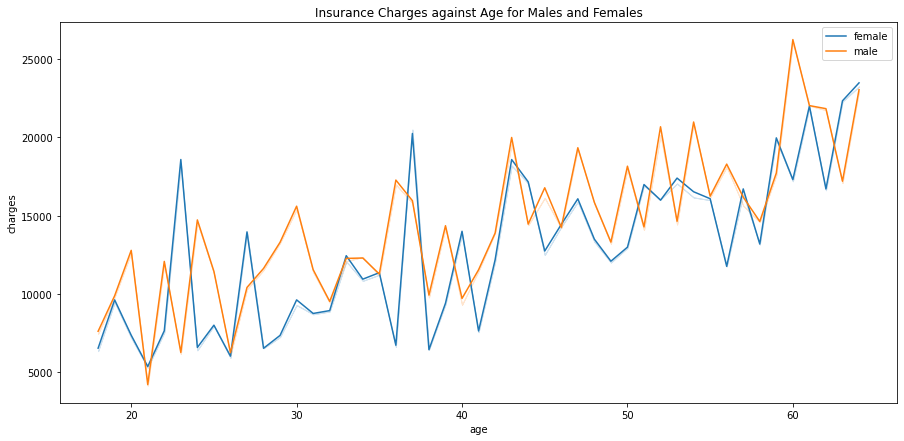

In [16]:
plt.figure(figsize=(15,7))
sns.lineplot(x=data["age"], y=data["charges"], hue=data["sex"], ci=0).set(title= 'Insurance Charges against Age for Males and Females')
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

From the lineplot, the charges tend to increase sharply for males as they get older.

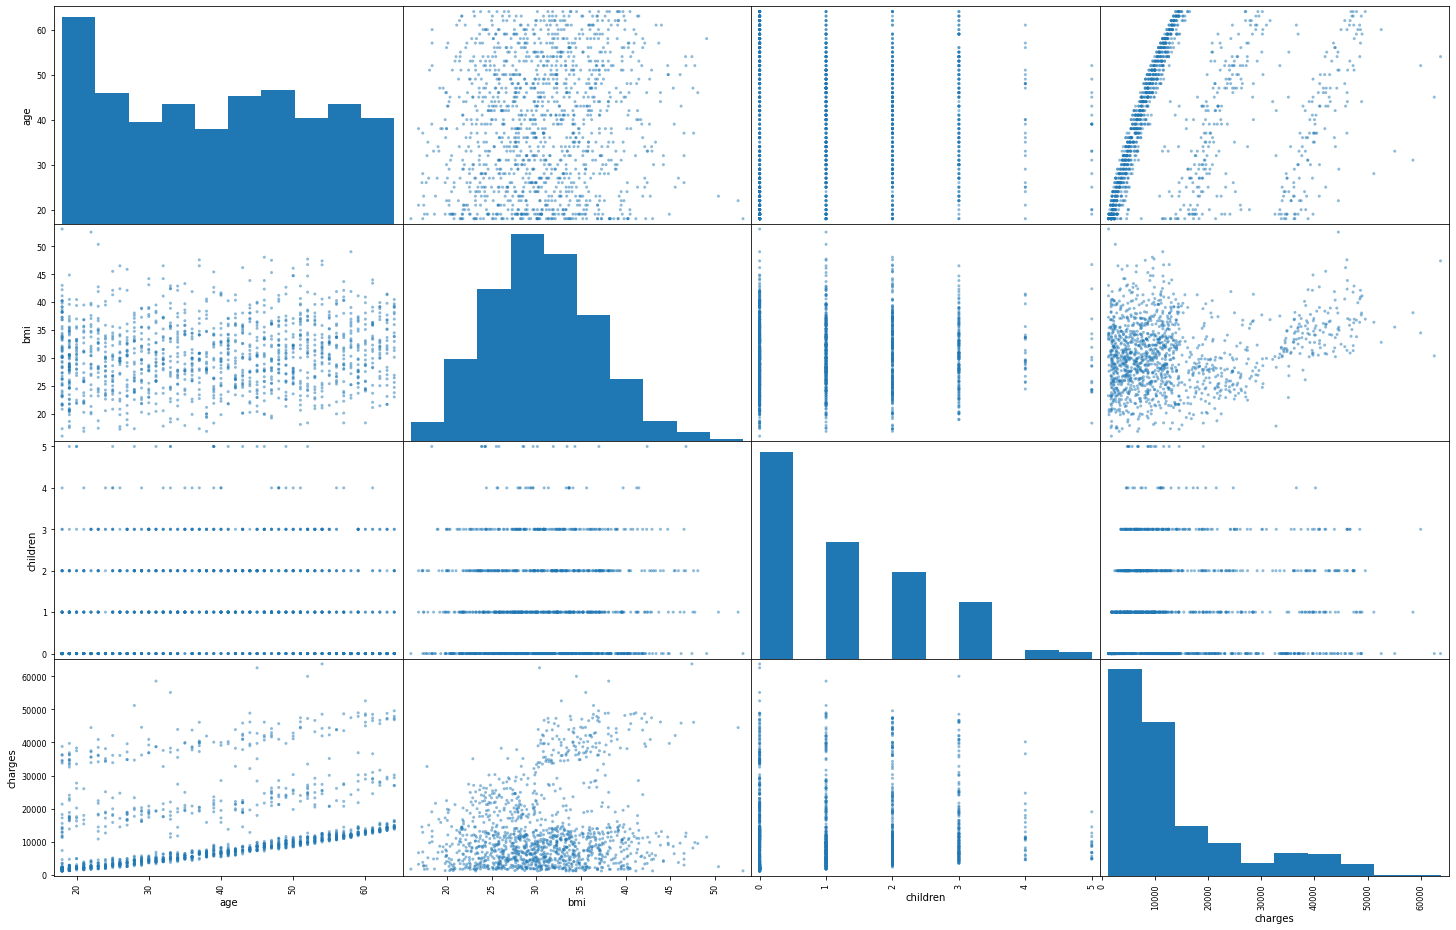

In [17]:
scatter_matrix(data,figsize=(25,16))
plt.show()

We are converting the regions using the dummy trick and replace them with numbers for creating proper categorical variables.

In [18]:
region = pd.get_dummies(data['region'], prefix='location')
data = pd.concat([data, region], axis=1)
data.drop(columns='region', inplace=True)

data['sex'].replace(to_replace=['male','female'], value=[1,0], inplace=True)
data['smoker'].replace(to_replace=['yes', 'no'], value=[1,0], inplace=True)

data.dtypes

smoker                  int64
sex                     int64
age                     int64
bmi                   float64
children                int64
charges               float64
location_northeast      uint8
location_northwest      uint8
location_southeast      uint8
location_southwest      uint8
dtype: object

<AxesSubplot:title={'center':'Correlation Matrix'}>

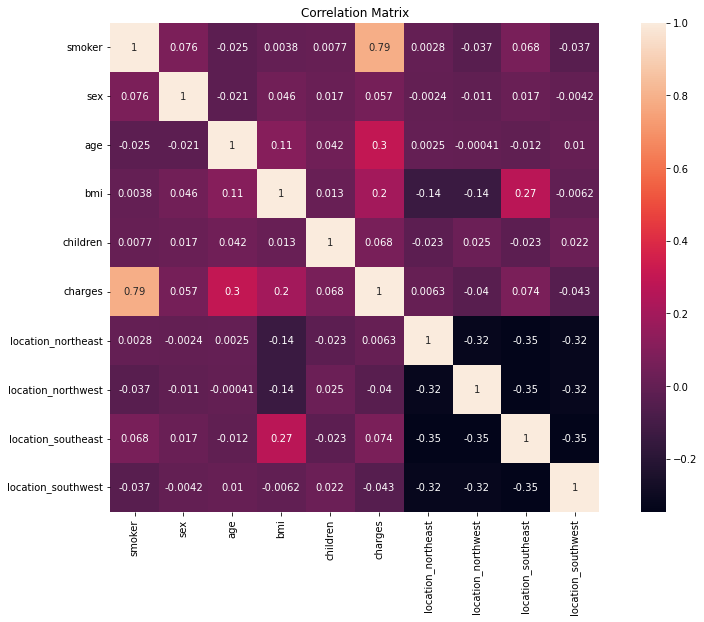

In [19]:
correlation = data.corr()
plt.figure(figsize=(15,9))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True)

The correlation plot confirms our observations that charges are most influenced by the smoker, age and bmi factors.

## Feature Engineering

We transform the charges to be closer to normal distribution.

In [20]:
data['charges'] = np.log(data['charges'])
data.head()

,smoker,sex,age,bmi,children,charges,location_northeast,location_northwest,location_southeast,location_southwest
0,1,0,19,27.900,0,9.734176,0,0,0,1
1,0,1,18,33.770,1,7.453302,0,0,1,0
2,0,1,28,33.000,3,8.400538,0,0,1,0
3,0,1,33,22.705,0,9.998092,0,1,0,0
4,0,1,32,28.880,0,8.260197,0,1,0,0


Based on our observations, we group similar people into clusters using KMeans, group the locations to north and south and the children to either more than 1 or less than 1.

In [21]:
features=['age', 'bmi', 'smoker', 'children', 'location_northeast', 'location_northwest', 'location_southeast', 'location_southwest']
kmeans = KMeans(n_clusters=2)
kmeans.fit(data[features])

data['cust_type'] = kmeans.predict(data[features])
data['location_north'] = data.apply(lambda x: 1 if (x['location_northeast'] == 1) or (x['location_northwest'] == 1) else 0, axis=1)
data['location_south'] = data.apply(lambda x: 1 if (x['location_southwest'] == 1) or (x['location_southeast'] == 1) else 0, axis=1)
data['more_than_1_child'] = data.children.apply(lambda x:1 if x>1 else 0)
data.drop(['location_northeast', 'location_northwest', 'location_southeast', 'location_southwest', 'children'], axis=1, inplace=True)

Now, we split the features and labels, create training and testing sets and scaling the numerical features.

In [22]:
X = data.drop(['charges'], axis=1).values
y = data['charges'].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
transformation = StandardScaler()
X_train = transformation.fit_transform(X_train)
X_test = transformation.transform(X_test)

## Training and Testing ML Regression Models

In [25]:
model = LinearRegression()

ttr = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
ttr.fit(X_train, y_train)

y_pred = ttr.predict(X_test)
print("MSE: " , mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

MSE:  0.16315532033668728
R2 Score:  0.8185430523479345


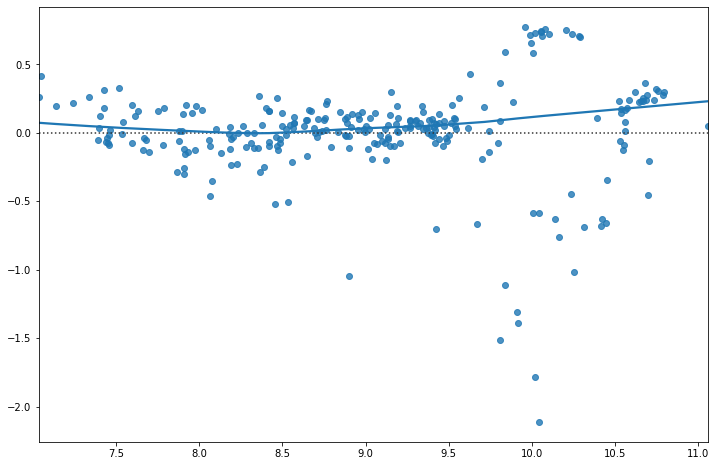

In [26]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.residplot(y_test, y_pred, lowess=True)

In [27]:
model = DecisionTreeRegressor(criterion='squared_error',splitter='best',random_state=42)

ttr = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
ttr.fit(X_train, y_train)

y_pred = ttr.predict(X_test)
print("MSE: " , mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

MSE:  0.20194437364918075
R2 Score:  0.7754029132346432


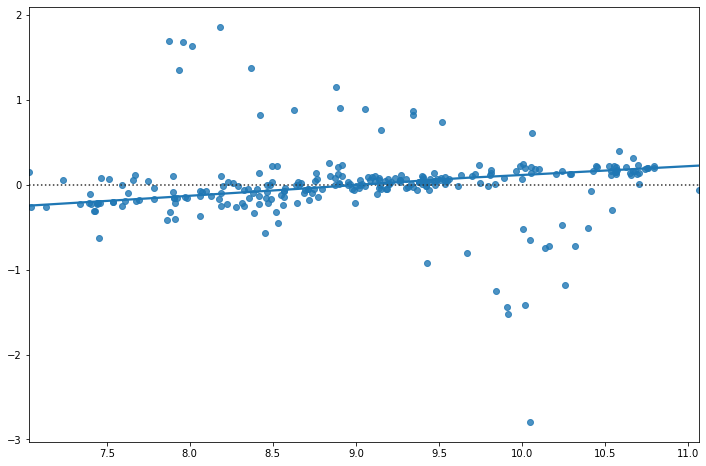

In [28]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.residplot(y_test, y_pred, lowess=True)

In [29]:
model = RandomForestRegressor(n_estimators=100,random_state=42)

ttr = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
ttr.fit(X_train, y_train)

y_pred = ttr.predict(X_test)
print("MSE: " , mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

MSE:  0.13733580241821036
R2 Score:  0.8472588239309047


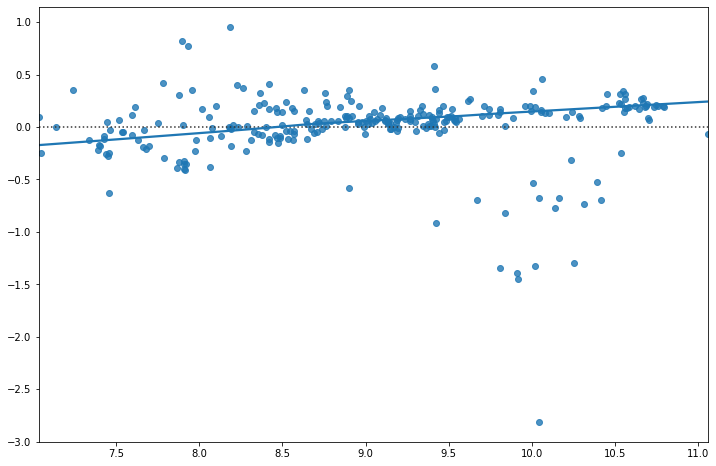

In [30]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.residplot(y_test, y_pred, lowess=True)

In [31]:
model = XGBRegressor(random_state=42)

ttr = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
ttr.fit(X_train, y_train)

y_pred = ttr.predict(X_test)
print("MSE: " , mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

MSE:  0.17512397139525568
R2 Score:  0.8052318413857742


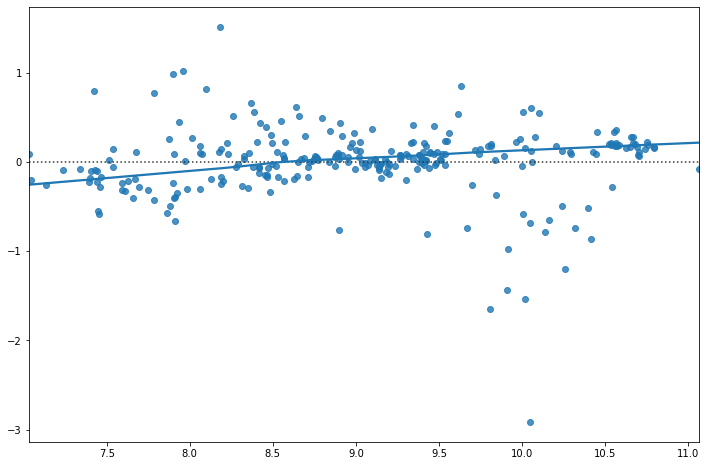

In [32]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.residplot(y_test, y_pred, lowess=True)

In [33]:
model = CatBoostRegressor(iterations = 1000, learning_rate = 0.075, depth = 3, loss_function = 'RMSE', eval_metric = 'RMSE', 
                          random_seed = 560, od_type = 'Iter', metric_period = 50, od_wait = 10, task_type="GPU", devices='0:1')

ttr = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
ttr.fit(X_train, y_train)

y_pred = ttr.predict(X_test)
print("MSE: " , mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

0:	learn: 0.9681362	total: 7.23ms	remaining: 7.22s
50:	learn: 0.4473404	total: 316ms	remaining: 5.89s
100:	learn: 0.4262507	total: 631ms	remaining: 5.61s
150:	learn: 0.4193586	total: 941ms	remaining: 5.29s
200:	learn: 0.4157487	total: 1.25s	remaining: 4.99s
250:	learn: 0.4127670	total: 1.59s	remaining: 4.75s
300:	learn: 0.4104483	total: 1.92s	remaining: 4.45s
350:	learn: 0.4095496	total: 2.25s	remaining: 4.16s
400:	learn: 0.4086789	total: 2.59s	remaining: 3.86s
450:	learn: 0.4075235	total: 2.94s	remaining: 3.58s
500:	learn: 0.4063677	total: 3.27s	remaining: 3.26s
550:	learn: 0.4058847	total: 3.66s	remaining: 2.98s
600:	learn: 0.4055735	total: 3.99s	remaining: 2.65s
650:	learn: 0.4050059	total: 4.34s	remaining: 2.32s
700:	learn: 0.4044875	total: 4.68s	remaining: 2s
750:	learn: 0.4041351	total: 5.01s	remaining: 1.66s
800:	learn: 0.4035927	total: 5.35s	remaining: 1.33s
850:	learn: 0.4032196	total: 5.68s	remaining: 994ms
900:	learn: 0.4029034	total: 6.01s	remaining: 661ms
950:	learn: 0.402

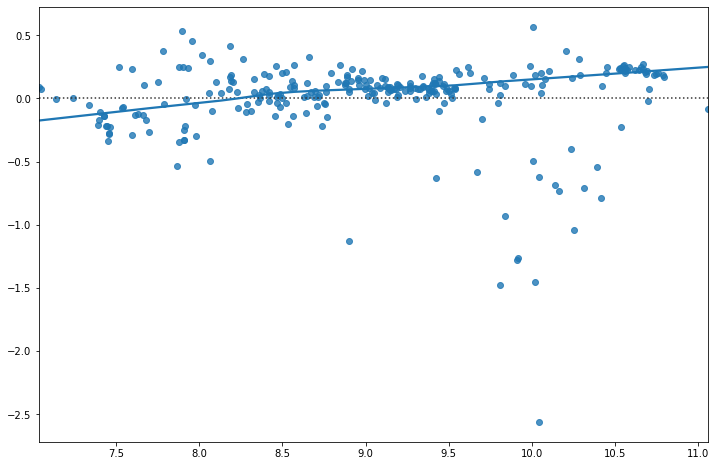

In [34]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.residplot(y_test, y_pred, lowess=True)

In [35]:
model = GradientBoostingRegressor(random_state=42)

ttr = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
ttr.fit(X_train, y_train)

y_pred = ttr.predict(X_test)
print("MSE: " , mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

MSE:  0.12366892486438534
R2 Score:  0.8624587566069215


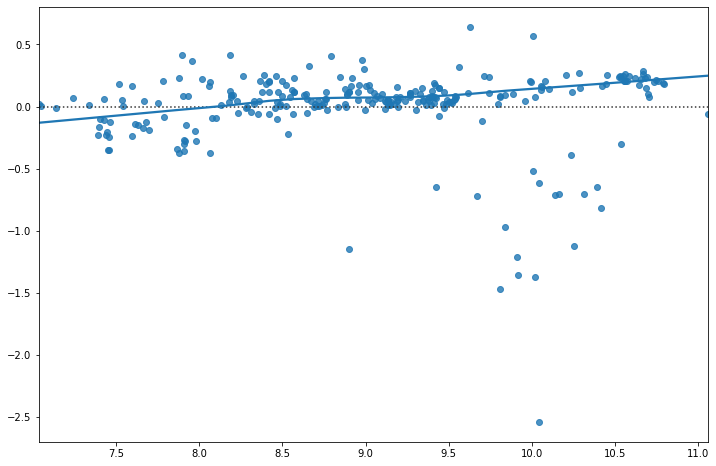

In [36]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.residplot(y_test, y_pred, lowess=True)

## Hyperparameter Tuning

We choose the Gradient Boosting Regressor as the best model and tune its parameters.

In [37]:
param_grid = {'learning_rate':[0.5, 0.10, 0.01, 0.1],
              'n_estimators':[25, 50, 75, 100, 125],
              'max_depth':[3, 5, 7, 9, 10],
              'subsample':[1, 2],
              'min_samples_split':[1, 2, 3],
              'min_samples_leaf':[1, 1.5, 2, 4],
              'max_depth':[5, 7, 9, 10]
             }

grid_search = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param_grid, cv=3, n_jobs=4, verbose=True, return_train_score=True)
grid_search.fit(X_train, y_train)

# Get the best set of parameters
print("Best Parameters: ", grid_search.best_params_)

# Calculate the score based on the best set of parameters
print("Score: ", grid_search.score(X_test, y_test))

Fitting 3 folds for each of 1920 candidates, totalling 5760 fits
Best Parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 25, 'subsample': 1}
Score:  0.854445165508537


## Save ML Regression model

In [38]:
model = GradientBoostingRegressor()
model = model.set_params(**grid_search.best_params_)
model.fit(X_train, y_train)
pickle.dump(model, open(FILE_NAME, 'wb'))

## Conclusion

Gradient Boosting Regressor is an ensemble Decision Tree regressor model. It builds an ensemble of shallow and weak trees where they learn from the previous trees. <br/>
This provides flexibility to the model to fit a larger group of features and provide better predictive accuracy, while being easy to tune for hyperparameters. <br/>
Hence, using this model, we were able to achieve the best accuracy, more so comparable to CatBoost Regressor, another great model.

We also conculde with the following observations:
1. Males incur higher charges than females.
2. Charges increase with age, which is the general consensus.
3. The southeast regions has the maximum number of people with charges.
4. Smoking incures higher charges and males who smoke have higher charges.
5. Non-smoking females have higher charges than smoking males.

End of Notebook